In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from scipy.stats import normaltest
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

import missingno as msno

import os
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras

import random
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

sns.set_theme(style="darkgrid", context= "paper")

In [2]:
HMDA_clean_final = pd.read_pickle("C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/interim/HMDA_clean_final.pkl")

In [3]:
HMDA_clean_final['loan_granted'] = (HMDA_clean_final['loan_granted'] == 'Granted').astype(int)

HMDA_encoded = 

X = HMDA_encoded.drop(columns=['loan_granted'])pd.get_dummies(HMDA_clean_final, columns=['applicant_sex', 'applicant_race-1', 'loan_type', 'debt_to_income_ratio', 'lien_status'], drop_first=True)
y = HMDA_encoded['loan_granted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [40]:
print(X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(545238, 19) (136310, 19) (170388, 19)
(545238,) (136310,) (170388,)


XXX

In [69]:
BLD_train_df = pd.get_dummies(HMDA_clean_final.loc[X_train.index], columns=['applicant_sex', 'applicant_race-1', 'loan_type', 'debt_to_income_ratio', 'lien_status'], drop_first=False)

In [73]:
for col in BLD_train_df.columns:
    if BLD_train_df[col].dtype == 'bool':
        BLD_train_df[col] = BLD_train_df[col].astype(int)

In [74]:
BLD_train_df.head()

,county_code,interest_rate,loan_to_value_ratio,loan_granted,applicant_sex_Male,applicant_sex_Female,applicant_race-1_Black or African American,applicant_race-1_White,loan_type_Conventional,loan_type_FHA,...,debt_to_income_ratio_36,debt_to_income_ratio_37%-41%,debt_to_income_ratio_41%-45%,debt_to_income_ratio_46%-49%,debt_to_income_ratio_50%-60%,debt_to_income_ratio_<20%,debt_to_income_ratio_>60%,debt_to_income_ratio_missing,lien_status_First lien,lien_status_Subordinate lien
115410,30013,4.990000,100.000000,1,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
630420,48119,4.560661,71.241202,0,1,0,1,0,1,0,...,0,0,0,1,0,0,0,0,1,0
612581,48085,4.560661,71.241202,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,1
670964,48085,4.560661,71.241202,1,1,0,0,1,1,0,...,0,0,0,0,0,1,0,0,1,0
179727,30111,7.000000,52.055000,1,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1


In [31]:
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.datasets import BinaryLabelDataset

In [79]:
privileged_groups = [{'applicant_race-1_White': 1}]
unprivileged_groups = [{'applicant_race-1_White': 0}]

privileged_groups_2 = [{'applicant_sex_Male': 1}]
unprivileged_groups_2 = [{'applicant_sex_Male': 0}]

train_bld = BinaryLabelDataset(df=BLD_train_df, label_names=['loan_granted'], protected_attribute_names=['applicant_race-1_White', 'applicant_race-1_Black or African American'], favorable_label=1.0, unfavorable_label=0.0)
train_bld_2 = BinaryLabelDataset(df=BLD_train_df, label_names=['loan_granted'], protected_attribute_names=['applicant_sex_Male', 'applicant_sex_Female'], favorable_label=1.0, unfavorable_label=0.0)


metric_orig_train = BinaryLabelDatasetMetric(train_bld, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

metric_orig_train_2 = BinaryLabelDatasetMetric(train_bld_2, 
                                             unprivileged_groups=unprivileged_groups_2,
                                             privileged_groups=privileged_groups_2)

print("Difference in mean outcomes between unprivileged and privileged groups - Race = %f" % metric_orig_train.mean_difference())
print("Difference in mean outcomes between unprivileged and privileged groups - Sex = %f" % metric_orig_train_2.mean_difference())

Difference in mean outcomes between unprivileged and privileged groups - Race = -0.148808
Difference in mean outcomes between unprivileged and privileged groups - Sex = -0.036731


In [80]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_train = RW.fit_transform(train_bld)

In [97]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Difference in mean outcomes between unprivileged and privileged groups - Race = %f" % metric_transf_train.mean_difference())

Difference in mean outcomes between unprivileged and privileged groups - Race = -0.000000


In [96]:
print(pd.DataFrame(train_bld.convert_to_dataframe()[0][["county_code", "interest_rate", "loan_to_value_ratio"]]).head(), "\n", "\n", X_train[["county_code", "interest_rate", "loan_to_value_ratio"]].head())

        county_code  interest_rate  loan_to_value_ratio
115410      30013.0       4.990000           100.000000
630420      48119.0       4.560661            71.241202
612581      48085.0       4.560661            71.241202
670964      48085.0       4.560661            71.241202
179727      30111.0       7.000000            52.055000 
 
        county_code  interest_rate  loan_to_value_ratio
115410       30013       4.990000           100.000000
630420       48119       4.560661            71.241202
612581       48085       4.560661            71.241202
670964       48085       4.560661            71.241202
179727       30111       7.000000            52.055000


In [5]:
'''
directory = 'C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/interim/'

os.makedirs(directory, exist_ok=True)

pickle_file = os.path.join(directory, 'subsets_data.pickle')

subsets = {
    'X_train_scaled': X_train_scaled,
    'X_test_scaled': X_test_scaled,
    'X_val_scaled': X_val_scaled,
    'y_train': y_train,
    'y_test': y_test,
    'y_val': y_val
}

with open(pickle_file, 'wb') as f:
    pickle.dump(subsets, f)
'''

"\ndirectory = 'C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/interim/'\n\nos.makedirs(directory, exist_ok=True)\n\npickle_file = os.path.join(directory, 'subsets_data.pickle')\n\nsubsets = {\n    'X_train_scaled': X_train_scaled,\n    'X_test_scaled': X_test_scaled,\n    'X_val_scaled': X_val_scaled,\n    'y_train': y_train,\n    'y_test': y_test,\n    'y_val': y_val\n}\n\nwith open(pickle_file, 'wb') as f:\n    pickle.dump(subsets, f)\n"

In [6]:
model = keras.Sequential([
    keras.layers.Dense(24, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001), input_shape=(X_train_scaled.shape[1],)),
    keras.layers.Dense(48, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(24, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=10, batch_size=32)

Epoch 1/10
17039/17039 [==============================] - 49s 3ms/step - loss: 0.3516 - accuracy: 0.8727 - val_loss: 0.3120 - val_accuracy: 0.8915
Epoch 2/10
17039/17039 [==============================] - 57s 3ms/step - loss: 0.3163 - accuracy: 0.8892 - val_loss: 0.3074 - val_accuracy: 0.8935
Epoch 3/10
17039/17039 [==============================] - 86s 5ms/step - loss: 0.3115 - accuracy: 0.8920 - val_loss: 0.3026 - val_accuracy: 0.8965
Epoch 4/10
17039/17039 [==============================] - 101s 6ms/step - loss: 0.3079 - accuracy: 0.8931 - val_loss: 0.3147 - val_accuracy: 0.8769
Epoch 5/10
17039/17039 [==============================] - 76s 4ms/step - loss: 0.3068 - accuracy: 0.8937 - val_loss: 0.3010 - val_accuracy: 0.8977
Epoch 6/10
17039/17039 [==============================] - 175s 10ms/step - loss: 0.3056 - accuracy: 0.8940 - val_loss: 0.2970 - val_accuracy: 0.8979
Epoch 7/10
17039/17039 [==============================] - 57s 3ms/step - loss: 0.3047 - accuracy: 0.8941 - val_loss

5325/5325 - 6s - loss: 0.3047 - accuracy: 0.8924 - 6s/epoch - 1ms/step

Test accuracy: 0.8924278616905212


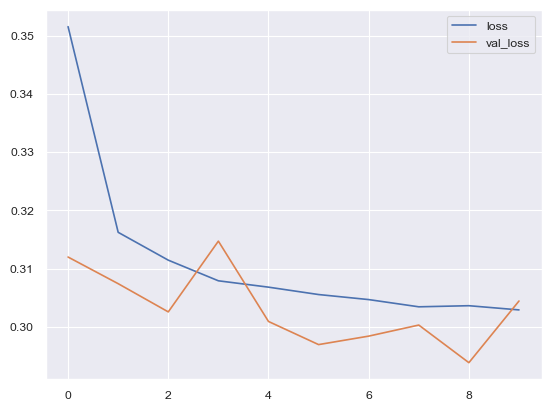

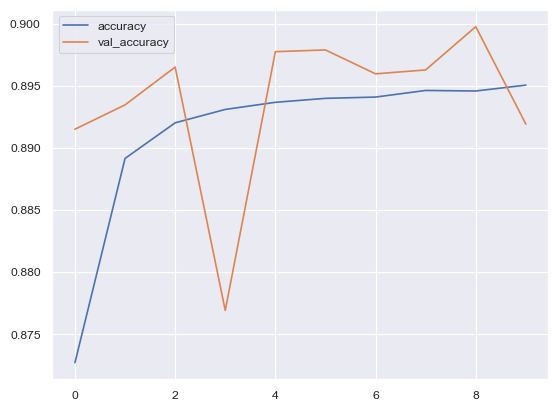

In [7]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

5325/5325 [==============================] - 7s 1ms/step
[[59237 12411]
 [ 5918 92822]]
Accuracy: 0.8924278705073128
Precision: 0.8820617106801099
Recall: 0.9400648166902977
F1 Score: 0.9101400675579611
AUC: 0.9389582591987764


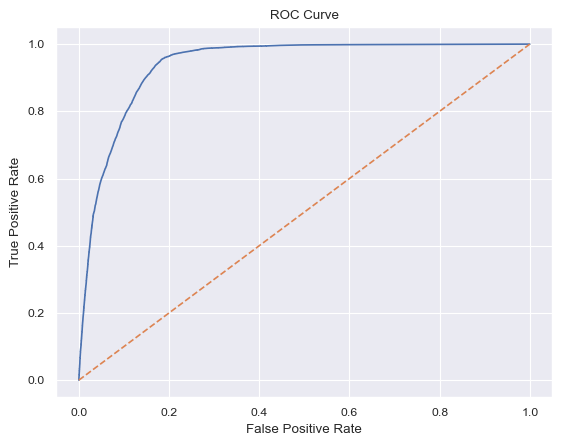

In [8]:
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5)
y_pred_proba = y_pred_proba.ravel()

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

from sklearn.metrics import roc_auc_score
print("AUC:", roc_auc_score(y_test, y_pred_proba))

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [9]:
results = pd.DataFrame({'label': y_test})
results["score"] = y_pred.astype(int)
results["applicant_sex"] = HMDA_clean_final.loc[results.index, "applicant_sex"]
results["applicant_race-1"] = HMDA_clean_final.loc[results.index, "applicant_race-1"]

results["label"] = results["label"].astype("int")
results["score"] = results["score"].astype("int")

results["applicant_sex"] = results["applicant_sex"].astype("object")
results["applicant_race-1"] = results["applicant_race-1"].astype("object")

In [10]:
print(results.head(), "\n", results.shape, "\n", results.dtypes)

        label  score applicant_sex           applicant_race-1
238575      1      1          Male                      White
328268      0      0          Male                      White
594872      1      1          Male                      White
635106      1      1          Male                      White
451212      0      0        Female  Black or African American 
 (170388, 4) 
 label                int32
score                int32
applicant_sex       object
applicant_race-1    object
dtype: object


In [11]:
import aequitas

audit = aequitas.Audit(results)

In [12]:
g = aequitas.group.Group()

results_ren = results.copy()
results_ren["label_value"] = results["label"]
results_ren.drop(columns="label", inplace=True)

xtab, _ = g.get_crosstabs(results_ren)

In [13]:
absolute_metrics = g.list_absolute_metrics(xtab)

xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,0,binary 0/1,105233,applicant_sex,Female,34144,25012,4050,2875,22137,30094,32969,26187,59156,170388
1,0,binary 0/1,105233,applicant_sex,Male,71089,40143,8361,3043,37100,62728,65771,45461,111232,170388
2,0,binary 0/1,105233,applicant_race-1,Black or African American,10603,15850,1405,2798,13052,9198,11996,14457,26453,170388
3,0,binary 0/1,105233,applicant_race-1,White,94630,49305,11006,3120,46185,83624,86744,57191,143935,170388


In [14]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,applicant_sex,Female,0.88,0.91,0.85,0.11,0.12,0.15,0.09,0.89,0.88,0.32,0.58,0.56
1,applicant_sex,Male,0.90,0.95,0.82,0.08,0.12,0.18,0.05,0.92,0.88,0.68,0.64,0.59
2,applicant_race-1,Black or African American,0.84,0.77,0.90,0.18,0.13,0.10,0.23,0.82,0.87,0.10,0.40,0.45
3,applicant_race-1,White,0.90,0.96,0.81,0.06,0.12,0.19,0.04,0.94,0.88,0.90,0.66,0.60


In [15]:
aqp = aequitas.plotting.Plot()

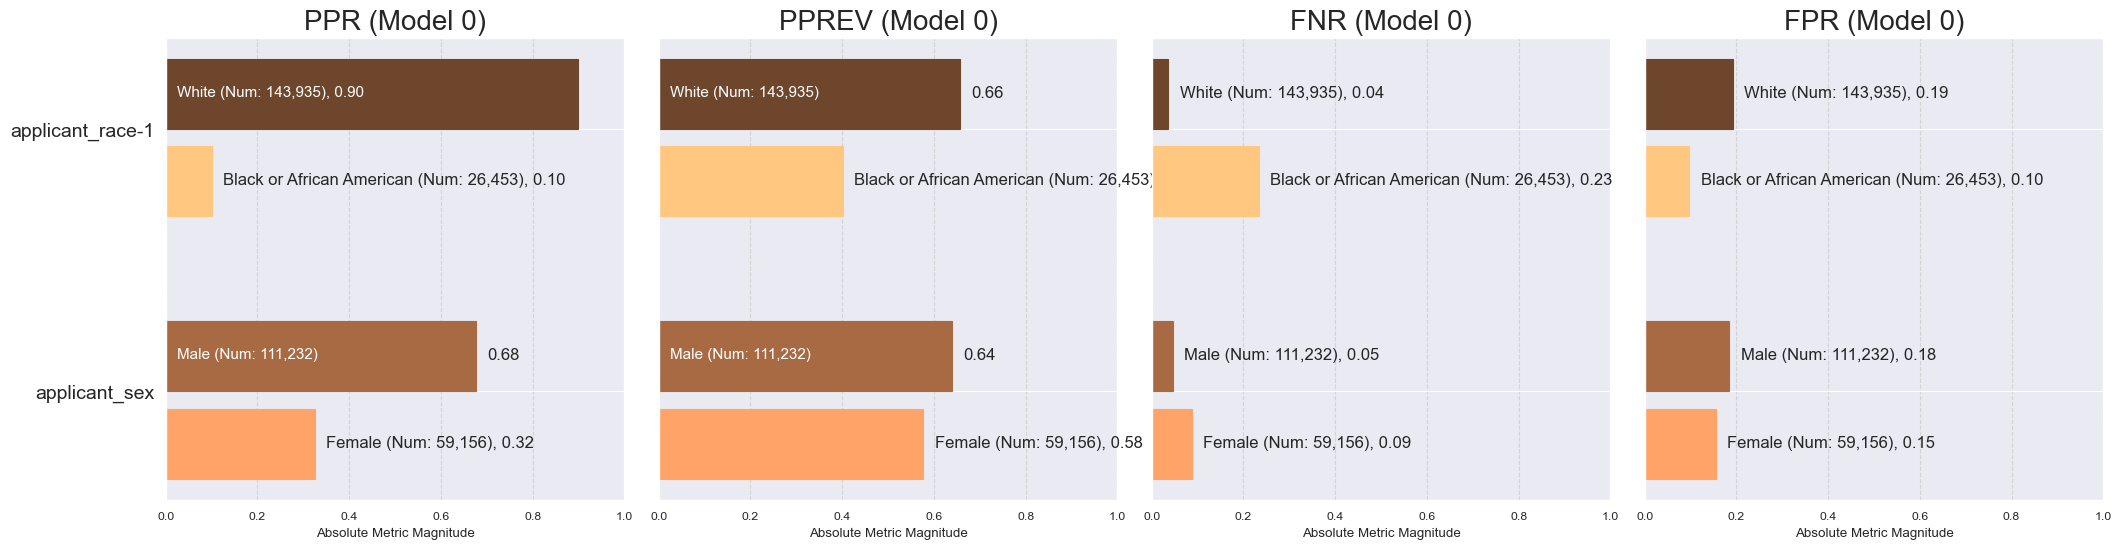

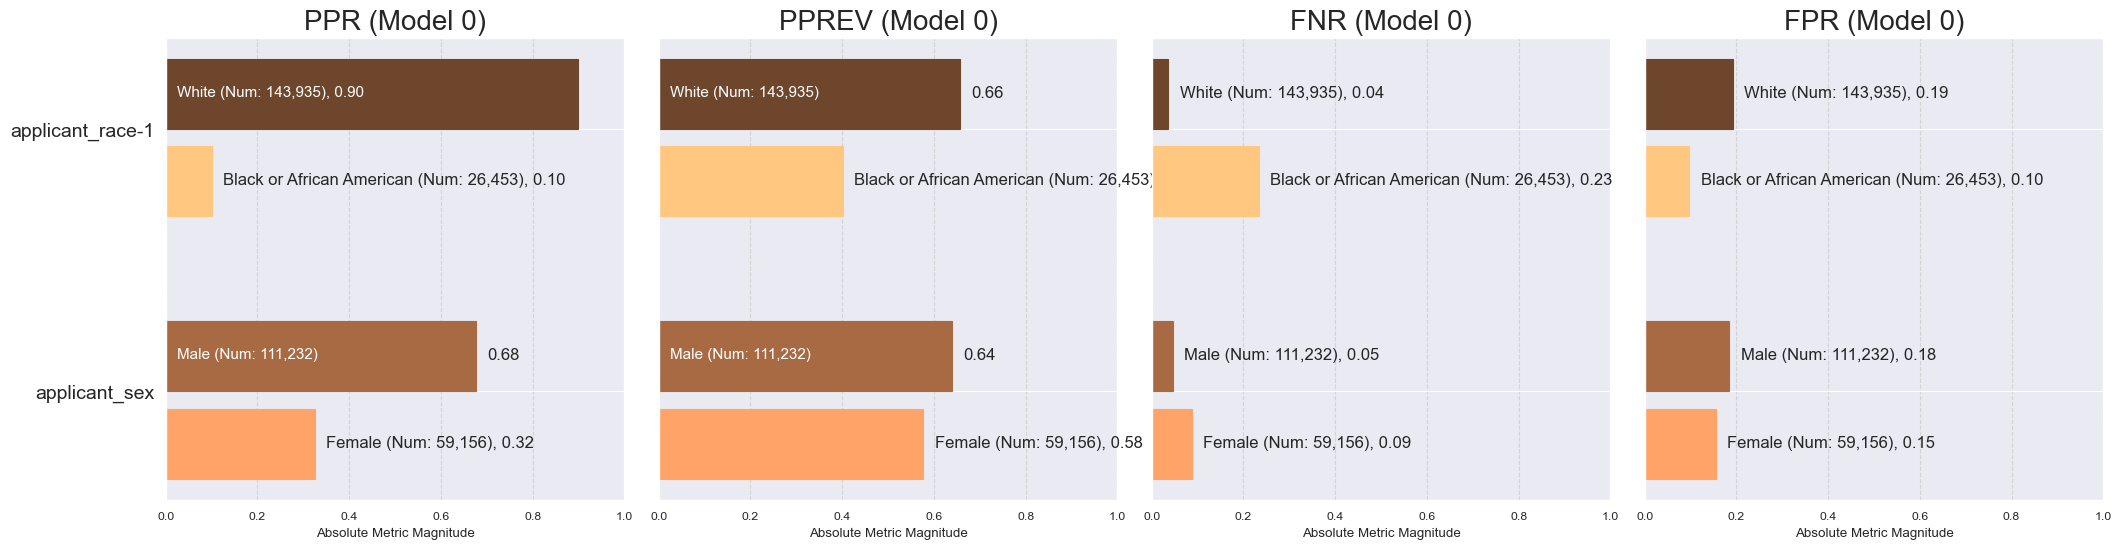

<Figure size 640x480 with 0 Axes>

In [16]:
aqp.plot_group_metric_all(xtab, metrics=['ppr','pprev','fnr','fpr'], ncols=4)

In [17]:
b = aequitas.bias.Bias()

In [18]:
bdf = b.get_disparity_predefined_groups(xtab, original_df=results_ren, ref_groups_dict={'applicant_race-1':'White', 'applicant_sex':'Male'}, alpha=0.05, mask_significance=True)
bdf.style

,model_id,score_threshold,k,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity,ppr_ref_group_value,pprev_ref_group_value,precision_ref_group_value,fdr_ref_group_value,for_ref_group_value,fpr_ref_group_value,fnr_ref_group_value,tpr_ref_group_value,tnr_ref_group_value,npv_ref_group_value
0,0,binary 0/1,105233,applicant_sex,Female,0.882937,0.912797,0.845343,0.114945,0.118615,0.154657,0.087203,0.885055,0.881385,34144,25012,0.324461,0.577186,4050,2875,22137,30094,32969,26187,59156,170388,0.557323,0.480299,0.903115,0.998864,1.008521,1.516342,0.840911,1.884797,0.957078,1.035853,0.957649,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male
1,0,binary 0/1,105233,applicant_sex,Male,0.897476,0.953733,0.816084,0.075804,0.117613,0.183916,0.046267,0.924196,0.882387,71089,40143,0.675539,0.639106,8361,3043,37100,62728,65771,45461,111232,170388,0.591296,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male
2,0,binary 0/1,105233,applicant_race-1,Black or African American,0.841114,0.766756,0.902815,0.176530,0.132510,0.097185,0.233244,0.823470,0.867490,10603,15850,0.100757,0.400824,1405,2798,13052,9198,11996,14457,26453,170388,0.453484,0.112047,0.609665,0.981663,1.139323,2.789683,0.505006,6.484793,0.795363,1.117958,0.879099,White,White,White,White,White,White,White,White,White,White
3,0,binary 0/1,105233,applicant_race-1,White,0.901858,0.964032,0.807557,0.063280,0.116306,0.192443,0.035968,0.936720,0.883694,94630,49305,0.899243,0.657450,11006,3120,46185,83624,86744,57191,143935,170388,0.602661,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,White,White,White,White,White,White,White,White,White,White


In [19]:
calculated_disparities = b.list_disparities(bdf)
disparity_significance = b.list_significance(bdf)

In [20]:
disparity_significance

[]

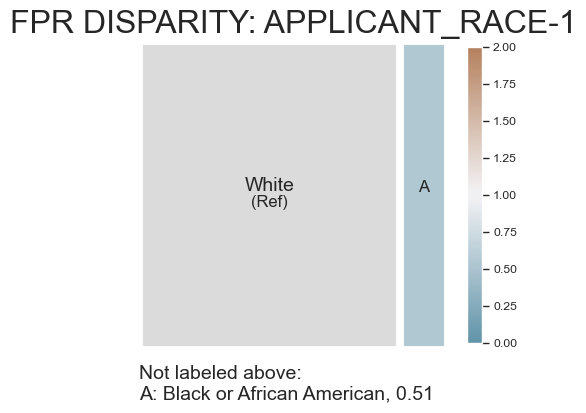

In [21]:
aqp.plot_disparity(bdf, group_metric='fpr_disparity', attribute_name='applicant_race-1', significance_alpha=0.05)